# image preprocessing

### 1. import

In [49]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from imutils.perspective import four_point_transform
from predictions import get_predictions

In [4]:
# some useful func to draw the result right in NB
def mpl_img_display(img, title):
    plt.imshow(img)
    plt.title(title)
    plt.xticks([]), plt.yticks([]) 
    plt.show()

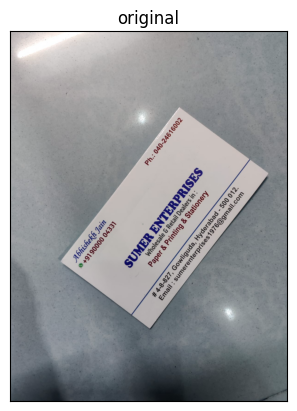

In [5]:
# the source image
img_original = cv2.imread('./images/03.jpg')

mpl_img_display(img_original, 'original')

In [6]:
cv2.namedWindow('original', cv2.WINDOW_NORMAL)
cv2.imshow('original', img_original)
cv2.waitKey(1)
cv2.destroyAllWindows()

### 2. resize and crop with openCV

In [7]:
# resize func
def resize_img(image, width: int = 500):
    # get W and H
    h, w, c = image.shape
    height = int((h / w) * width)
    size = (width, height)
    image = cv2.resize(image, size)
    return image, size

New size:  (500, 666)


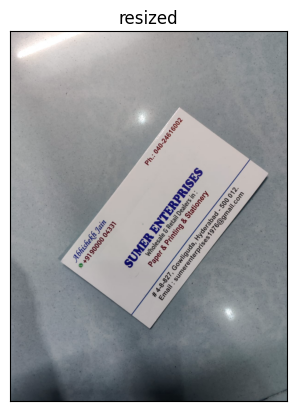

In [8]:
img_resized, size = resize_img(img_original)
print("New size: ", size)

mpl_img_display(img_resized, 'resized')

In [9]:
cv2.namedWindow('resized', cv2.WINDOW_NORMAL)
cv2.imshow('original', img_resized)
cv2.waitKey(1)
cv2.destroyAllWindows()

### 3. Enhancement

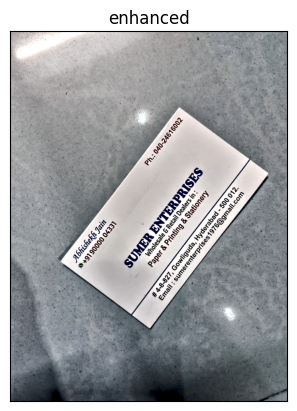

In [10]:
# try to enhance the qulity 
img_detailed = cv2.detailEnhance(img_resized, 
                                sigma_s=20, 
                                sigma_r=0.15)

mpl_img_display(img_detailed, 'enhanced')

In [11]:
cv2.imshow('resized', img_resized)
cv2.imshow('enhanced', img_detailed)
cv2.waitKey(1)
cv2.destroyAllWindows()

### 4. Grayscale, Bluring, Edge detection

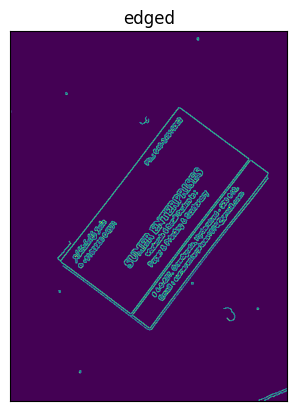

In [12]:
# the sequence of image manipulations to perform the edges pointing out
img_gray = cv2.cvtColor(img_detailed, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
img_edged = cv2.Canny(img_blur, 75, 200)

mpl_img_display(img_edged, 'edged')

cv2.imshow('resized', img_resized)
cv2.imshow('edged', img_edged)
cv2.waitKey(1)
cv2.destroyAllWindows()

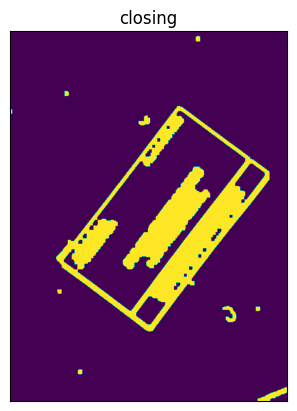

In [13]:
# edging with morphological transformation
kernel = np.ones((5, 5), dtype=np.uint8)
dilate = cv2.dilate(img_edged, kernel, iterations=1)
closing = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, kernel)

mpl_img_display(closing, 'closing')

cv2.imshow('dilated', dilate)
cv2.imshow('closing', closing)
cv2.waitKey(1)
cv2.destroyAllWindows()

### 5. Find contours

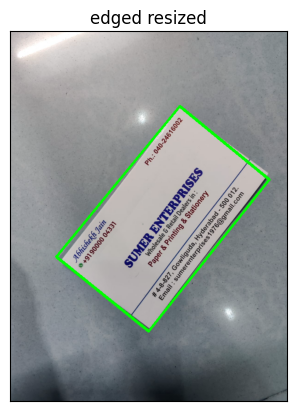

In [14]:
# and finaly draw points of edges determined 
contours, hire = cv2.findContours(closing, 
                                 cv2.RETR_LIST,
                                 cv2.CHAIN_APPROX_NONE)

contours = sorted(contours, key=cv2.contourArea, reverse=True)
for contour in contours:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
    if len(approx) == 4:
        points = np.squeeze(approx)
        break
        
cv2.drawContours(img_resized, [points], -1, (0, 255, 0), 3)

cv2.imshow('resized contour', img_resized)
cv2.imshow('closing', closing)
cv2.waitKey(1)
cv2.destroyAllWindows()

mpl_img_display(img_resized, 'edged resized')

In [15]:
# get polyline coordinates for the original image
# just divide original width on resized width
multiplier = img_original.shape[1] / size[0]
# restore points from resized to original
original_perimeter = (multiplier * points).astype(int)
print(original_perimeter)

[[ 732  324]
 [ 199  974]
 [ 597 1296]
 [1118  640]]


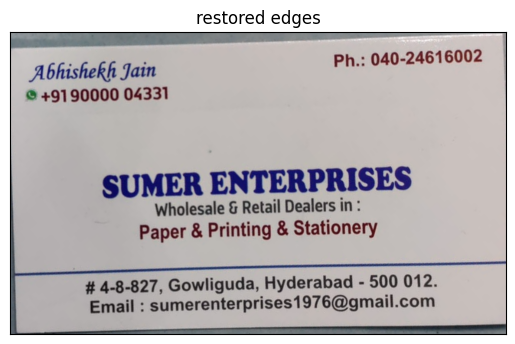

In [16]:
# try to display restored points
wrap_image = four_point_transform(img_original, \
                                  original_perimeter)

mpl_img_display(wrap_image, 'restored edges')

cv2.imshow('wrapped contour', wrap_image)
cv2.waitKey(1)
cv2.destroyAllWindows()

# Put it all together

In [29]:
def document_scanner(image):
    img_resized, size = resize_img(image)
    img_detailed = cv2.detailEnhance(img_resized, 
                                sigma_s=20, 
                                sigma_r=0.15)
    img_gray = cv2.cvtColor(img_detailed, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
    img_edged = cv2.Canny(img_blur, 75, 200)
    kernel = np.ones((5, 5), np.uint8)
    dilate = cv2.dilate(img_edged, kernel, iterations=1)
    closing = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, kernel)
    contours, hire = cv2.findContours(closing, 
                                 cv2.RETR_LIST,
                                 cv2.CHAIN_APPROX_NONE)
    
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
        if len(approx) == 4:
            points = np.squeeze(approx)
            break
            
    cv2.drawContours(img_resized, [points], -1, (0, 255, 0), 3)
    multiplier = image.shape[1] / size[0]
    original_perimeter = (multiplier * points).astype(int)
    wrap_image = four_point_transform(image, \
                                  original_perimeter)
    return wrap_image, original_perimeter, img_resized, closing

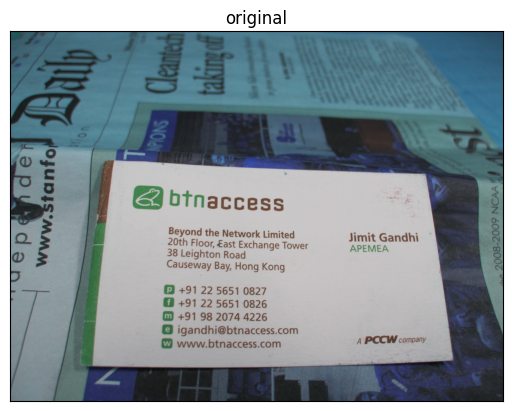

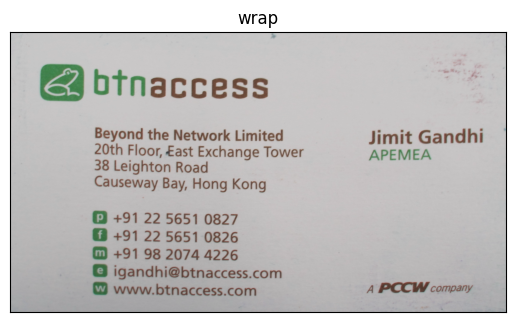

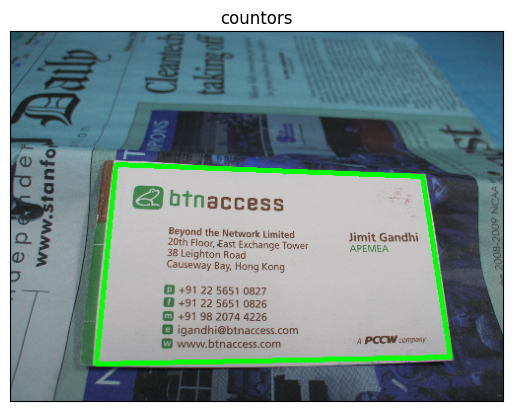

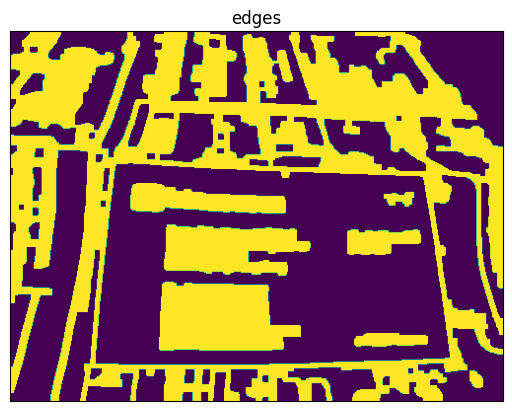

In [74]:
img = cv2.imread('./images/033.jpg')
wrap_image, points, countour_image, edged_image = document_scanner(img)

for img, title in zip([img, wrap_image, countour_image, edged_image], 
                      ["original", "wrap", "countors", "edges"]):
    mpl_img_display(img, title)

### Some tricks to improve contrast and brightness

In [75]:
def apply_brightness_contrast(input_img, brightness=0, contrast=0):
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)
    return buf

In [76]:
rgb = cv2.cvtColor(wrap_image,cv2.COLOR_BGR2RGB)
magic_image = apply_brightness_contrast(rgb,120,0)
magic_image_c1 = apply_brightness_contrast(rgb,0,40)
magic_image_c2 = apply_brightness_contrast(rgb,50,40)

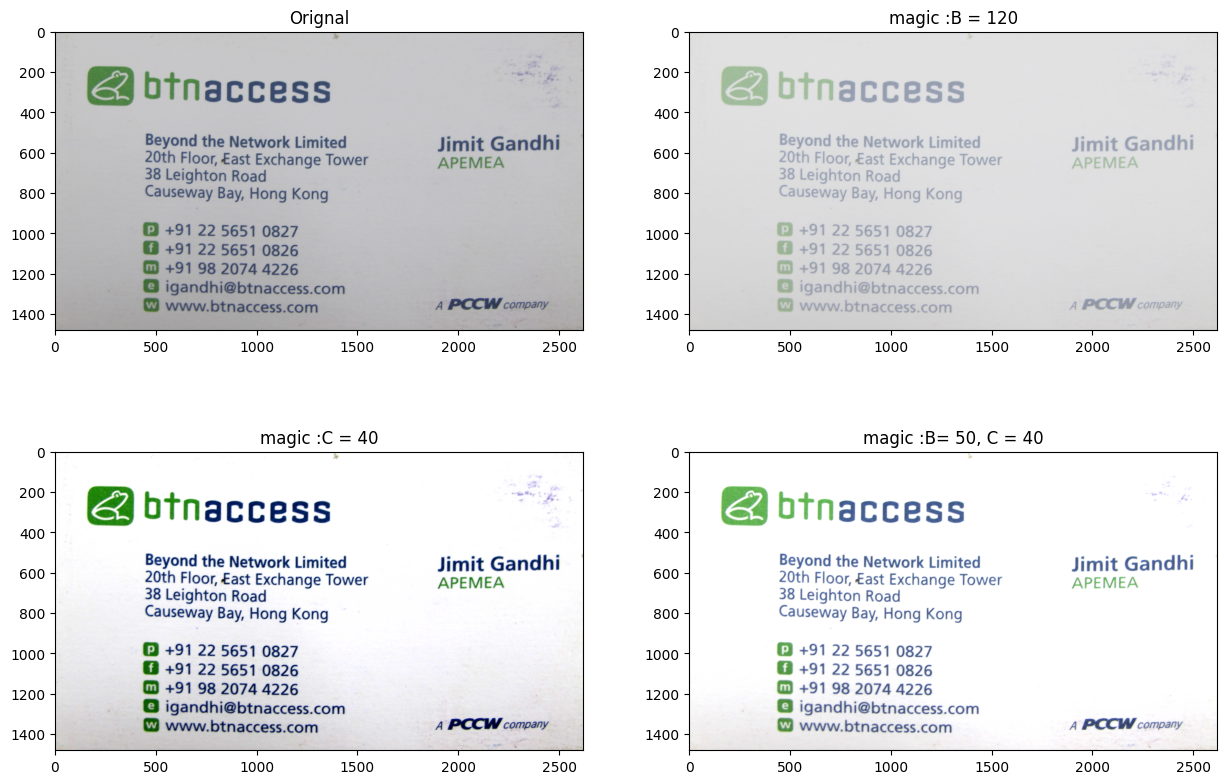

In [77]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(rgb)
plt.title('Orignal')

plt.subplot(2,2,2)
plt.imshow(magic_image)
plt.title('magic :B = 120')

plt.subplot(2,2,3)
plt.imshow(magic_image_c1)
plt.title('magic :C = 40')


plt.subplot(2,2,4)
plt.imshow(magic_image_c2)
plt.title('magic :B= 50, C = 40')

plt.show()

## Integrate with NER spacy model
### Get predictions

In [78]:
content, image_boxed, entities = get_predictions(magic_image_c2) 

In [79]:
content

'@abtnaccess beyond the network limited jimit gandhi 20th floor, east exchange tower apemea 38 leighton road causeway bay, hong kong © 91 22 5651 0827 91 22 5651 0826 91 98 2074 4226 igandhi@btnaccess.com ompany www.btnaccess.com a pocw comp'

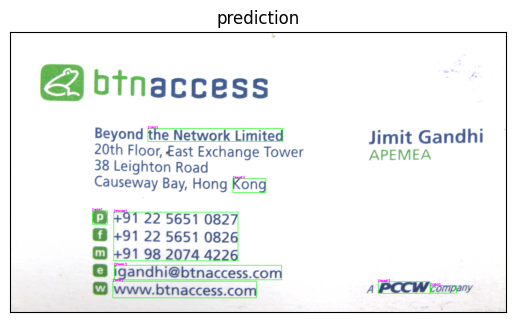

In [80]:
mpl_img_display(image_boxed, "prediction")

In [82]:
entities

{'NAME': ['Kong', 'Pocw'],
 'ORG': ['The Network Limited', 'Comp'],
 'DES': [],
 'PHONE': ['912256510827', '912256510826', '20744226'],
 'EMAIL': ['igandhi@btnaccess.com'],
 'WEB': ['', 'www.btnaccess.com']}